In [1]:
# import modules
%matplotlib inline

import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from lasagne import layers
from scipy.misc import imread, imresize
from theano.tensor.nnet import softmax
from sklearn.feature_extraction import image
from nolearn.lasagne import NeuralNet, BatchIterator
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score

script_root = '/home/faizy/workspace/project/project/scripts/'
data_root = '/home/faizy/workspace/project/project/datasets/'
model_root = '/home/faizy/workspace/project/project/models/'

chars74k_root = 'English/'

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [ ]:
def shiftup(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        # loop for shift up
        for j in range(16):
            shifted_dataset[i, 0, j:j+1, :] = dataset[i, 0, 16 + j : 16 + j + 1, :]
        for j in range(16, 32):
            shifted_dataset[i, 0, j:j+1, :] = shifted_dataset[i, :, 15, :]
    return shifted_dataset

In [ ]:
def shiftdown(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(16, 32):
            shifted_dataset[i, 0, j:j+1, :] = dataset[i, 0, j - 16 : j + 1 - 16, :]
        for j in range(16):
            shifted_dataset[i, 0, j:j+1, :] = shifted_dataset[i, :, 16, :]
    return shifted_dataset

In [ ]:
def shiftleft(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(16):
            shifted_dataset[i, 0, :, j:j+1] = dataset[i, 0, :, 16 + j: 16 + j + 1]
        for j in range(16, 32):
            shifted_dataset[i, :, :, j] = shifted_dataset[i, :, :, 15]
    
    return shifted_dataset

In [ ]:
def shiftright(dataset):
    shifted_dataset = np.zeros(dataset.shape)
    # loop for images
    for i in range(dataset.shape[0]):
        for j in range(16, 32):
            shifted_dataset[i, 0, :, j : j + 1] = dataset[i, 0, :, j - 16 : j + 1 - 16]
        for j in range(16):
            shifted_dataset[i, 0, :, j] = dataset[i, 0, :, 15]
    
    return shifted_dataset

In [ ]:
# load train_test set
# chars74k
data = pd.read_csv(script_root + 'LISTFILE.txt', sep = ' ', header = None)

data_x = np.zeros((data.shape[0], 1, 32, 32))
data_y = np.ones((data.shape[0], )).astype('int32')

for idx, path in enumerate(data[0]):
    img = imread(data_root + chars74k_root + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')

# inefficient but trial
train1_x = data_x
train1_y = data_y

In [ ]:
# Augmented data
train3_x = shiftup(train1_x)
train4_x = shiftdown(train1_x)
train5_x = shiftleft(train1_x)
train6_x = shiftright(train1_x)

train3_y = np.zeros((train3_x.shape[0], )).astype('int')
train4_y = np.zeros((train4_x.shape[0], )).astype('int')
train5_y = np.zeros((train5_x.shape[0], )).astype('int')
train6_y = np.zeros((train6_x.shape[0], )).astype('int')

In [ ]:
print train1_x.shape, train3_x.shape, train4_x.shape, train5_x.shape, train6_x.shape

In [ ]:
# preprocess
# chars74k
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

# augmented data

train3_x /= train3_x.std(axis = None)
train3_x -= train3_x.mean()

train4_x /= train4_x.std(axis = None)
train4_x -= train4_x.mean()

train5_x /= train5_x.std(axis = None)
train5_x -= train5_x.mean()

train6_x /= train6_x.std(axis = None)
train6_x -= train6_x.mean()

In [ ]:
# finally
train_x = np.vstack((train1_x, train3_x))
train_x = np.vstack((train_x, train4_x))
train_x = np.vstack((train_x, train5_x))
train_x = np.vstack((train_x, train6_x))

train_y = np.concatenate([train1_y, train3_y, train4_y, train5_y, train6_y])

In [ ]:
# check again
train_x = train_x.astype('float32')
train_y = train_y.astype('int32')

In [ ]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (5, 5),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (5, 5),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.2,
    conv3_num_filters = 128, conv3_filter_size = (5, 5),
    hidden4_num_units = 128,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 1000),
    batch_iterator_test = BatchIterator(batch_size = 1000),

    update_learning_rate = 0.003,
    update_momentum = 0.9,

    use_label_encoder = True,
    regression = False,
    max_epochs = 100,
    verbose = 1,
)

In [ ]:
# train and test nn
net.fit(train_x, train_y);

In [ ]:
f = open(model_root + 'detection_tester.pkl', 'wb')
pkl.dump(net, f)
f.close()

In [2]:
f = open(model_root + 'detector_2.pkl', 'rb')
net = pkl.load(f)
f.close()

In [4]:
img = imread('/home/faizy/workspace/project/project/datasets/svt/svt1/img/00_12.jpg')[292:451, 176:849, :]#[y:y+height, x:x+width]#imread('/home/faizy/workspace/project/project/datasets/svt/svt1/img/02_12.jpg')#[267:311, 523:656, :]

In [5]:
patches = image.extract_patches(img, (159, 100, 3), extraction_step = 5)
print patches.shape

(1, 115, 1, 159, 100, 3)


In [6]:
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, 0, :, :, :], (32, 32)))
        
print len(new_lst)

115


In [7]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32)

In [8]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [9]:
print tester.shape

(115, 1, 32, 32)


In [10]:
preder = net.predict_proba(tester)

In [11]:
heatmap = preder[:, 1].reshape((patches.shape[0], patches.shape[1]))
print heatmap.shape

(1, 115)


/home/faizy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


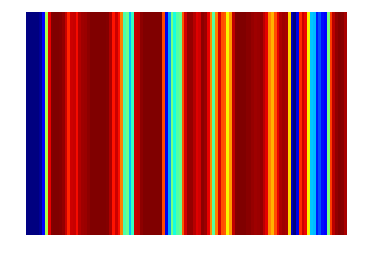

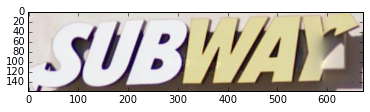

In [12]:
pylab.pcolor(heatmap[::-1])
pylab.axis('off')
pylab.show()
pylab.imshow(img)
pylab.show()

In [14]:
a = np.reshape(heatmap, patches.shape[1]*patches.shape[0])
print a.shape

(115,)


In [ ]:
for i in range(80, 120):
    pylab.plot(a[i, :])
    pylab.show()

In [34]:
from scipy.ndimage.filters import maximum_filter
peakind = np.nonzero(maximum_filter (a, size=(patches.shape[1]/5)*0.6) == a)[0]

In [35]:
peakind #= np.array([2, 6, 9, 13, 18, 22])

array([ 10,  26,  46,  63,  76,  92, 112])

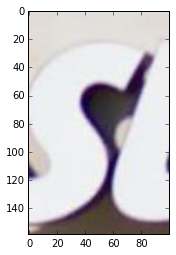

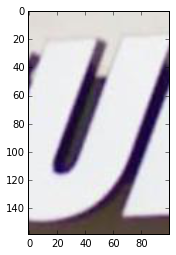

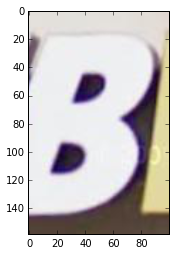

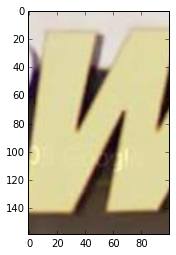

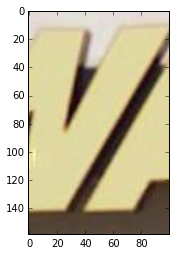

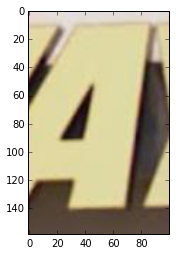

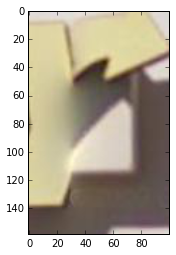

In [36]:
for i in peakind:
    pylab.imshow(img[:, i*5:i*5+100, :])
    pylab.show()

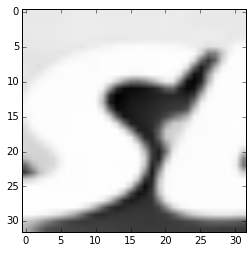

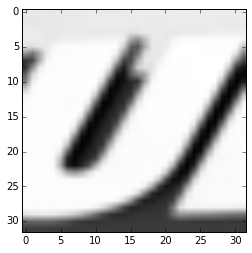

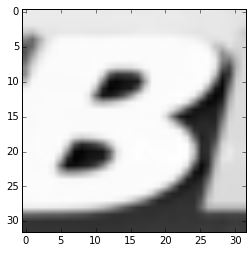

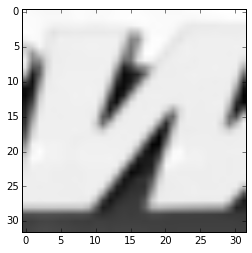

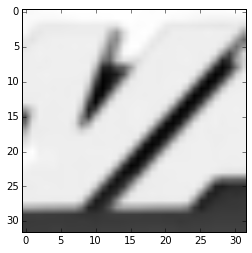

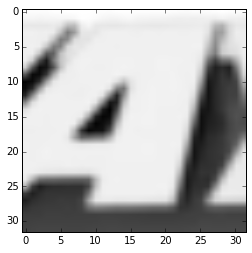

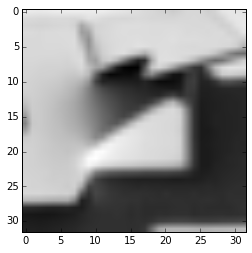

In [37]:
for i in peakind:
    pylab.imshow(tester[i, 0, :, :])
    pylab.gray()
    pylab.show()

In [55]:
word = np.zeros((7, 1, 32, 32))
for idx, item in enumerate(peakind):
    word[idx, ...] = tester[item, 0, :, :]
    
word = word.astype('float32')

In [56]:
# Load model
f = open(model_root + 'recognizer_1.pkl', 'rb')
netter = pkl.load(f)
f.close()

In [57]:
predict = netter.predict(word)

In [58]:
# Define word recognition functions
import re, collections

def words(text): return re.findall('[a-z]+', text.lower()) 

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

NWORDS = train(words(file(data_root + 'big.txt').read()))

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
   splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
   deletes    = [a + b[1:] for a, b in splits if b]
   transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
   replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
   inserts    = [a + c + b     for a, b in splits for c in alphabet]
   return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words): return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return sorted(candidates,  key=NWORDS.get, reverse = True)

def classer(arrayer):
    classer_array = []
    for i in range(len(arrayer)):
        if (0 <= arrayer[i] < 10):
            classer_array.append(arrayer[i])
        elif (10 <= arrayer[i] < 36) :
            classer_array.append(alphabet[arrayer[i] - 10].upper())
        elif (36 <= arrayer[i] < 62):
            classer_array.append(alphabet[arrayer[i] - 36])
        else : 
            print 'Is the array correct!?'
    return classer_array

In [59]:
real_pred = classer(predict)
real_pred = map(str, real_pred)
letter_stream = ''.join(real_pred).lower()

In [60]:
print letter_stream

kvx4zjh


In [ ]:
print 'Probable words are: ', ', '.join(correct(letter_stream))